## Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
# Load data
df = pd.read_csv('PFE-Pfizer.csv')

## Data preprocessing

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-03-01,41.375713,41.546490,41.072105,41.138519,33.265743,26667781
2019-03-04,41.214420,41.356735,40.683113,40.863377,33.043259,22805820
2019-03-05,40.882355,41.034157,40.654648,40.692600,32.905163,26529812
2019-03-06,40.626186,40.673622,39.487667,39.715370,32.114948,22410359
2019-03-07,39.715370,39.743832,39.136623,39.269451,31.754372,29046132
...,...,...,...,...,...,...
2024-05-24,28.670000,28.990000,28.549999,28.879999,28.879999,22576300
2024-05-28,28.799999,28.879999,28.129999,28.299999,28.299999,32371200
2024-05-29,28.160000,28.170000,27.690001,27.820000,27.820000,24241700


## Scale Data

In [4]:
# Select 'Close' column
data = df['Close'].values

In [5]:
# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

## Split the data into train and test

In [6]:
# Define the size of train and test
train_size = int(len(data_scaled) * 0.6)
test_size = len(data_scaled) - train_size

# Split the data into train and test set
train_data = data_scaled[0 : train_size, :]
test_data = data_scaled[train_size : len(data_scaled), :]

## Create and add data into X, y

In [7]:
def add_data(data, sequence_length=1):
    X, Y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : (i + sequence_length), 0])
        Y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(Y)

In [8]:
# Reshape into X=t,t+1,t+2..t+60 and Y=t+60
sequence_length = 60

# Get last data for test
train_last_windowsize = train_data[-sequence_length:]

test_data_extended = np.concatenate((train_last_windowsize, test_data), axis=0)

X_train, y_train = add_data(train_data, sequence_length)
X_test, y_test = add_data(test_data_extended, sequence_length)

# Reshape inputs to [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Build Model

In [9]:
model = Sequential() # Encapsulate the sequence of the inner layers

# 4 LSTM layers
model.add(LSTM(units = 50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# 1 Dense layer
model.add(Dense(units=1)) 

# Optimizer
model.compile(optimizer = 'adam', loss='mean_squared_error')

D:\Anaconda\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training Model

In [10]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
23/23 - 9s - 370ms/step - loss: 0.0305
Epoch 2/50
23/23 - 2s - 77ms/step - loss: 0.0092
Epoch 3/50
23/23 - 2s - 91ms/step - loss: 0.0077
Epoch 4/50
23/23 - 2s - 91ms/step - loss: 0.0075
Epoch 5/50
23/23 - 2s - 94ms/step - loss: 0.0076
Epoch 6/50
23/23 - 2s - 95ms/step - loss: 0.0054
Epoch 7/50
23/23 - 2s - 94ms/step - loss: 0.0068
Epoch 8/50
23/23 - 3s - 116ms/step - loss: 0.0053
Epoch 9/50
23/23 - 3s - 122ms/step - loss: 0.0051
Epoch 10/50
23/23 - 3s - 128ms/step - loss: 0.0046
Epoch 11/50
23/23 - 4s - 166ms/step - loss: 0.0041
Epoch 12/50
23/23 - 3s - 143ms/step - loss: 0.0050
Epoch 13/50
23/23 - 4s - 160ms/step - loss: 0.0041
Epoch 14/50
23/23 - 3s - 132ms/step - loss: 0.0044
Epoch 15/50
23/23 - 3s - 124ms/step - loss: 0.0035
Epoch 16/50
23/23 - 3s - 120ms/step - loss: 0.0040
Epoch 17/50
23/23 - 2s - 107ms/step - loss: 0.0034
Epoch 18/50
23/23 - 3s - 120ms/step - loss: 0.0044
Epoch 19/50
23/23 - 3s - 116ms/step - loss: 0.0041
Epoch 20/50
23/23 - 3s - 114ms/step - loss: 0.

## Predict and Inverse Transform the Predictions

In [11]:
y_pred = model.predict(X_test)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step


## Calculate the error of the model

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error, mean_absolute_error
# Evaluate the accuracy of test

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_msle = mean_squared_log_error(y_test, y_pred)


print(f"MAPE on Test dataset: ", test_mape)
print(f"RMSE on Test dataset: ", test_rmse)
print(f"MSLE on Test dataset: ", test_msle)
print(f"MAE on Test dataset: ", test_mae)

MAPE on Test dataset:  0.02280091626960858
RMSE on Test dataset:  1.1132115397792757
MSLE on Test dataset:  0.0007594718003414585
MAE on Test dataset:  0.8726066885638543


## Predict Close price for 90 next days

In [13]:
# Select the last day of current index
last_date = df.index[-1]

# Add a new day after the last day
next_date = last_date + pd.DateOffset(days=1)

# Generate a list of index only starting from the next day in 90 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Predict Close price for 90 next days
last_sequence_days = data_scaled[-sequence_length:].reshape(1, -1, 1)

y_next_90_days = []

for i in range(90):
    # Predict Close price for next day
    next_day_pred = model.predict(last_sequence_days)
    
    # Save the predict value
    y_next_90_days.append(next_day_pred[0][0])
    
    # Update information of the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

In [14]:
# Show the result of predict 90 next days 
y_next_90_days = scaler.inverse_transform(np.array(y_next_90_days).reshape(-1, 1))
print(y_next_90_days.flatten())

[28.66245  28.504412 28.385078 28.30488  28.254667 28.22202  28.197039
 28.173708 28.149612 28.12469  28.100016 28.076975 28.05672  28.039803
 28.026499 28.016884 28.010984 28.00871  28.010012 28.014854 28.023216
 28.034815 28.04958  28.06729  28.087988 28.11132  28.137232 28.165312
 28.195415 28.227308 28.260654 28.295006 28.330229 28.366125 28.402466
 28.439283 28.47595  28.512228 28.548    28.582571 28.616125 28.648602
 28.679731 28.709585 28.737719 28.764225 28.789038 28.811895 28.832924
 28.851938 28.869041 28.884356 28.897831 28.90945  28.918947 28.92703
 28.933386 28.938345 28.94195  28.94403  28.944698 28.944225 28.942772
 28.940422 28.937271 28.933422 28.928982 28.924067 28.918787 28.913248
 28.907555 28.901806 28.896088 28.890488 28.885082 28.87994  28.875126
 28.870699 28.866707 28.86319  28.860186 28.85772  28.855812 28.854479
 28.853724 28.853548 28.853947 28.85491  28.85642  28.858458]


## Model visualization

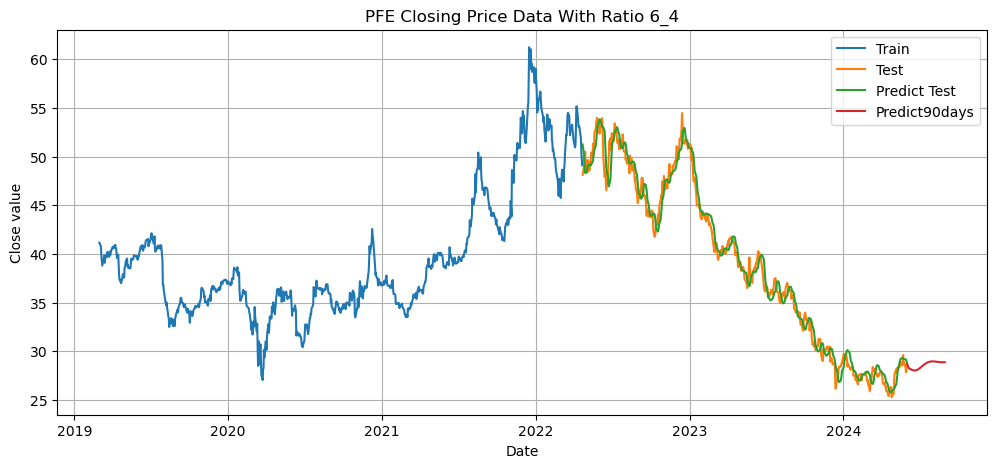

In [15]:
plt.figure(figsize=(12, 5))

# Train set
plt.plot(df[:train_size].index, train_data)

# Test set
plt.plot(df[train_size:].index, test_data)

# Predict in test set
plt.plot(df[train_size:].index, y_pred)

# Predict 90 next days
plt.plot(index_next_90_days, y_next_90_days)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict90days'])
plt.grid()
plt.title("PFE Closing Price Data With Ratio 6_4")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('Image/RNN_64_90days_PFE.png')
plt.show()